In [196]:
# Imports
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import hvplot.pandas
import warnings

## Part 1: Prepare the Data

In [197]:
warnings.filterwarnings("ignore", category=FutureWarning)
file_path = Path("Resources/myopia.csv")
df = pd.read_csv(file_path)
df.head(10)

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0
5,6,1.744,22.139999,3.224,3.556,15.36,10,6,2,1,19,44,0,1,0
6,6,0.683,22.330000,3.186,3.654,15.49,12,7,2,1,8,36,0,1,0
7,6,1.272,22.389999,3.732,3.584,15.08,12,0,0,0,8,8,0,0,0
8,7,1.396,22.620001,3.464,3.408,15.74,4,0,3,1,3,12,0,0,0
9,6,0.972,22.740000,3.504,3.696,15.54,30,5,1,0,10,27,0,0,0


In [198]:
#Remove the "MYOPIC" column from the dataset.Note: The target column is needed for supervised machine learning, but it will make an unsupervised model biased. After all, the target column is effectively providing clusters already!
df = df.drop(columns=["MYOPIC"])
df .head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0


In [199]:
#Standardize your dataset so that columns that contain larger values do not influence the outcome more than columns with smaller values.
scaler = StandardScaler()
X = scaler.fit_transform(df)
print("Number of rows and features in scaled dataframe:", X.shape)

Number of rows and features in scaled dataframe: (618, 14)


## Part 2: Apply Dimensionality Reduction

In [200]:
n_components = n_components=.90
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print("Number of rows and features in transformed data:", X_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Number of rows and features in transformed data: (618, 10)
Explained variance ratio: 0.9187361702915187


In [201]:
#Creating a dataframe for 2D and 3D plotting of cluster groups. 
pca_df = pd.DataFrame(data=X_pca)

In [211]:
#After testing multiple learning rates and perplexity peremeters, I decided to go with 900 and 5. 
tsne = TSNE(learning_rate=900, perplexity=5)
tsne_features = tsne.fit_transform(X_pca)
print("Number of rows and features in tsne data:",tsne_features.shape)


Number of rows and features in tsne data: (618, 2)


In [212]:
#creating X and Y columns needed for plotting 2D and 3D cluster charts. 

pca_df["x"] = tsne_features[:,0]
pca_df["y"] = tsne_features[:,1]


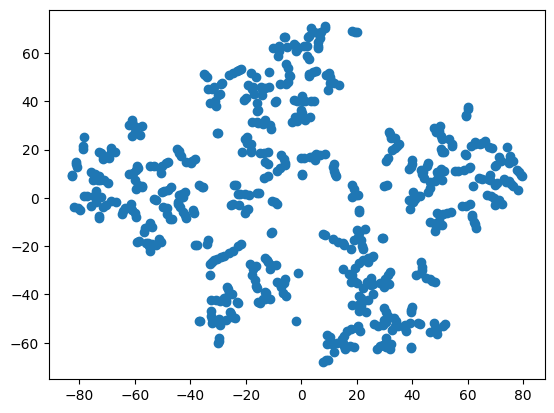

In [213]:
plt.scatter(tsne_features[:,0],tsne_features[:,1])

## Part 3: Perform a Cluster Analysis with K-means

In [214]:
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(pca_df)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

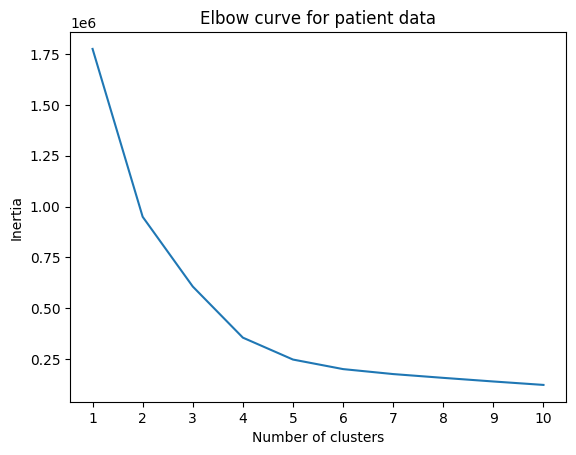

In [215]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for patient data')
plt.show()

In [216]:
#creating a loop to test multiple clusters to confirm the best possible cluster group. 


max_score = -1
max_cluster = -1
# iterate over cluster sizes and calculate silhouette scores to determine the clusters with the best score. 
for n_clusters in range(2, 10):
    # fit the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pca_df)
    
    # predict cluster labels
    predictions = kmeans.predict(pca_df)
    
    # calculate silhouette score
    silhouette_avg = silhouette_score(pca_df, predictions)
    
    print(f"Cluster size: {n_clusters}, Silhouette score: {silhouette_avg:.3f}")

    if silhouette_avg > max_score:
        max_score = silhouette_avg
        max_cluster = n_clusters

print(f"Best silhouette score: {max_score:.3f} with {max_cluster} clusters")


Cluster size: 2, Silhouette score: 0.425
Cluster size: 3, Silhouette score: 0.442
Cluster size: 4, Silhouette score: 0.492
Cluster size: 5, Silhouette score: 0.517
Cluster size: 6, Silhouette score: 0.511
Cluster size: 7, Silhouette score: 0.474
Cluster size: 8, Silhouette score: 0.436
Cluster size: 9, Silhouette score: 0.434
Best silhouette score: 0.517 with 5 clusters


In [217]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)
    
    # Calculate the Silhouette score
    silhouette_avg = silhouette_score(data, predictions)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data
#setting up this cluster to auto adjust based on the max silhouette score. 
clusters = get_clusters(max_cluster, pca_df)

In [218]:
#2D view of the class clusters. 
clusters.hvplot.scatter(
    x="x",
    y="y",
    hover_cols=["class"],
    by="class",
)

:NdOverlay   [class]
   :Scatter   [x]   (y,class)

In [219]:
# 3D  view of the class clusters. 
fig = px.scatter_3d(
    clusters,
    x="x",
    y="y",
    z="class",
    color="class",
    symbol="class",
    width=700,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Based on the fine-tuned TSNE model and the silhouette score analysis conducted on the elbow_data, I recommend grouping the patients into 5 clusters. 